# Food Ingredient Classifier Training

- **Authors:** Riyaadh Gani
- **Project:** Food Recognition & Recipe LLM
- **Purpose:** Train a deep learning classifier to identify food ingredients from images

**Dataset:** [Scuccorese/food-ingredients-dataset](https://huggingface.co/datasets/Scuccorese/food-ingredients-dataset)
- 6,676 images
- 316 ingredient classes
- 12 categories, 28 subcategories

**Models:** EfficientNet-B0 and ResNet50 (comparison)

**Pipeline:** YOLO crops → This Classifier → Ingredient labels → LLM → Recipes

---

## Notebook Sections

1. Setup & Installation
2. Data Loading & Exploration
3. Data Preprocessing & Augmentation
4. Model Architecture (EfficientNet-B0)
5. Training Loop
6. Evaluation & Metrics
7. Model Comparison (ResNet50)
8. Confusion Matrix
9. Save & Export
10. Test on Sample Crops

---
## 1. Setup & Installation

In [1]:
# Install required packages
!pip install -q datasets transformers torch torchvision timm pillow matplotlib seaborn scikit-learn tqdm

In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from datasets import load_dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA L4
Memory: 23.80 GB


In [3]:
# Mount Google Drive (for saving models)
from google.colab import drive
drive.mount('/content/drive')

# Create output directory
OUTPUT_DIR = "/content/drive/MyDrive/LLM_Models/cooking-assistant-project/food-classifier"
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✓ Output directory: {OUTPUT_DIR}")

Mounted at /content/drive
✓ Output directory: /content/drive/MyDrive/LLM_Models/cooking-assistant-project/food-classifier


---
## 2. Data Loading & Exploration

In [4]:
# Load dataset from HuggingFace
print("Loading dataset from HuggingFace...")
dataset = load_dataset("Scuccorese/food-ingredients-dataset")

print(f"\n✓ Dataset loaded successfully!")
print(f"Total samples: {len(dataset['train'])}")
print(f"\nDataset structure:")
print(dataset)

Loading dataset from HuggingFace...


README.md:   0%|          | 0.00/407 [00:00<?, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/367M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/476M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6676 [00:00<?, ? examples/s]


✓ Dataset loaded successfully!
Total samples: 6676

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['category', 'subcategory', 'ingredient', 'image'],
        num_rows: 6676
    })
})


Sample data point:
  Category: vegetables
  Subcategory: leafy
  Ingredient: spinach
  Image: <class 'PIL.WebPImagePlugin.WebPImageFile'>


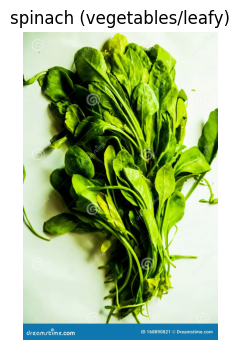

In [5]:
# Explore dataset structure
sample = dataset['train'][0]
print("Sample data point:")
print(f"  Category: {sample['category']}")
print(f"  Subcategory: {sample['subcategory']}")
print(f"  Ingredient: {sample['ingredient']}")
print(f"  Image: {type(sample['image'])}")

# Display sample image
plt.figure(figsize=(4, 4))
plt.imshow(sample['image'])
plt.title(f"{sample['ingredient']} ({sample['category']}/{sample['subcategory']})")
plt.axis('off')
plt.show()

In [6]:
# Analyze class distribution (FAST VERSION)
print("Analyzing dataset... (this may take 1-2 minutes)")

# Convert to pandas for faster processing
import pandas as pd

# Option 1: Use dataset.to_pandas() if available
try:
    df = dataset['train'].to_pandas()
    print("✓ Converted to pandas")
except:
    # Option 2: Manual conversion (slower but works)
    print("Converting to pandas manually...")
    data_dict = {
        'ingredient': [],
        'category': [],
        'subcategory': []
    }

    # Use tqdm for progress bar
    from tqdm.auto import tqdm
    for item in tqdm(dataset['train'], desc="Loading data"):
        data_dict['ingredient'].append(item['ingredient'])
        data_dict['category'].append(item['category'])
        data_dict['subcategory'].append(item['subcategory'])

    df = pd.DataFrame(data_dict)
    print("✓ Converted to pandas")

# Now analyze (FAST!)
ingredient_counts = df['ingredient'].value_counts()
category_counts = df['category'].value_counts()
subcategory_counts = df['subcategory'].value_counts()

print(f"\n📊 Dataset Statistics:")
print(f"  Total images: {len(df)}")
print(f"  Unique ingredients: {df['ingredient'].nunique()}")
print(f"  Unique categories: {df['category'].nunique()}")
print(f"  Unique subcategories: {df['subcategory'].nunique()}")

print(f"\nTop 10 ingredients:")
for ingredient, count in ingredient_counts.head(10).items():
    print(f"  {ingredient}: {count} images")

print(f"\nCategory distribution:")
for category, count in category_counts.items():
    print(f"  {category}: {count} images")


Analyzing dataset... (this may take 1-2 minutes)
✓ Converted to pandas

📊 Dataset Statistics:
  Total images: 6676
  Unique ingredients: 316
  Unique categories: 12
  Unique subcategories: 28

Top 10 ingredients:
  cake flour: 40 images
  watercress: 40 images
  mustard greens: 40 images
  gluten-free flour: 40 images
  all-purpose flour: 40 images
  coconut sugar: 40 images
  self-rising flour: 40 images
  muscovado sugar: 40 images
  bread flour: 40 images
  oat flour: 40 images

Category distribution:
  fruits: 967 images
  vegetables: 964 images
  legumes: 779 images
  canned: 768 images
  meats: 763 images
  grains: 569 images
  baking: 568 images
  packaged: 553 images
  pasta: 194 images
  jars: 189 images
  olives: 184 images
  oils: 178 images


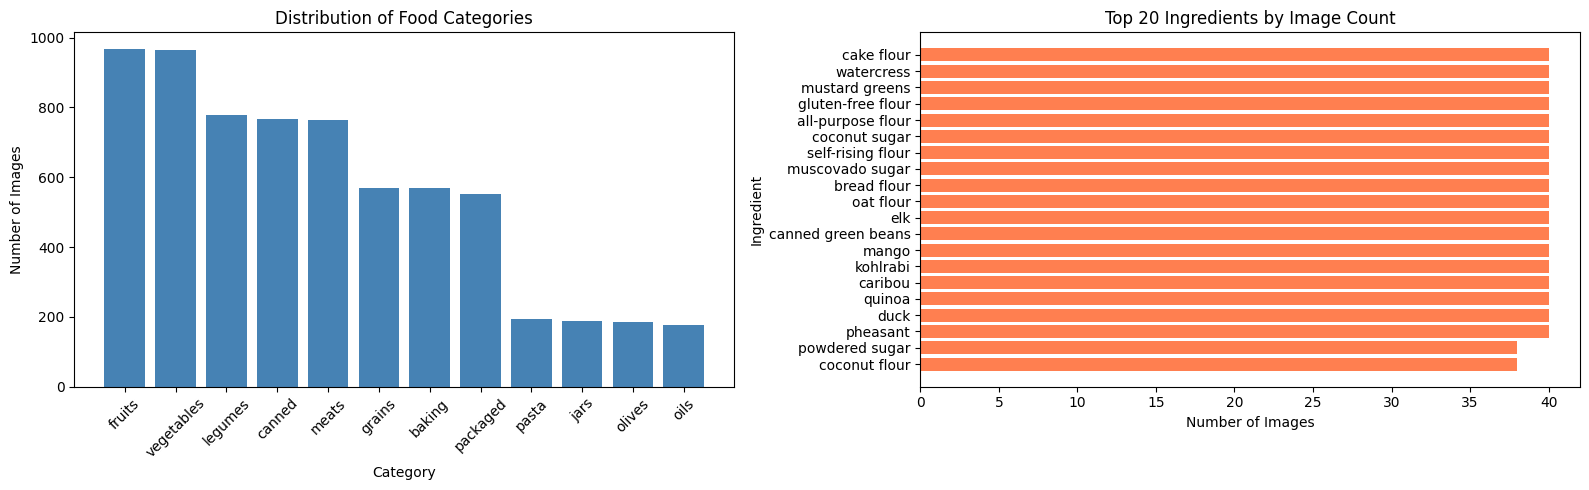

✓ Distribution plot saved


In [7]:
# Visualize category distribution (FIXED)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Category distribution
# Use .index and .values for pandas Series
categories_list = category_counts.index.tolist()
counts_list = category_counts.values.tolist()
ax1.bar(categories_list, counts_list, color='steelblue')
ax1.set_xlabel('Category')
ax1.set_ylabel('Number of Images')
ax1.set_title('Distribution of Food Categories')
ax1.tick_params(axis='x', rotation=45)

# Top 20 ingredients
top_20_ingredients = ingredient_counts.head(20)
ingredients_list = top_20_ingredients.index.tolist()
counts_list = top_20_ingredients.values.tolist()
ax2.barh(ingredients_list[::-1], counts_list[::-1], color='coral')
ax2.set_xlabel('Number of Images')
ax2.set_ylabel('Ingredient')
ax2.set_title('Top 20 Ingredients by Image Count')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/dataset_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Distribution plot saved")

In [8]:
# Create ingredient to label mapping
unique_ingredients = sorted(df['ingredient'].unique().tolist())
ingredient_to_label = {ingredient: idx for idx, ingredient in enumerate(unique_ingredients)}
label_to_ingredient = {idx: ingredient for idx, ingredient in enumerate(unique_ingredients)}  # ← Integer keys!

num_classes = len(unique_ingredients)
print(f"\n✓ Created label mappings for {num_classes} classes")

# Save mappings (convert int keys to str for JSON)
with open(f"{OUTPUT_DIR}/ingredient_to_label.json", 'w') as f:
    json.dump(ingredient_to_label, f, indent=2)

with open(f"{OUTPUT_DIR}/label_to_ingredient.json", 'w') as f:
    # Convert int keys to str for JSON compatibility
    label_to_ingredient_str = {str(k): v for k, v in label_to_ingredient.items()}
    json.dump(label_to_ingredient_str, f, indent=2)

print(f"✓ Label mappings saved to {OUTPUT_DIR}")



✓ Created label mappings for 316 classes
✓ Label mappings saved to /content/drive/MyDrive/LLM_Models/cooking-assistant-project/food-classifier


---
## 3. Data Preprocessing & Augmentation

In [9]:
# Split dataset into train/val/test (80/10/10) - MEMORY EFFICIENT
print("Splitting dataset (memory-efficient)...")

# Instead of loading all images, just store indices and metadata
data_indices = []
data_labels = []

print("Creating index mapping...")
for idx in tqdm(range(len(dataset['train'])), desc="Indexing"):
    item = dataset['train'][idx]
    data_indices.append({
        'idx': idx,
        'ingredient': item['ingredient'],
        'category': item['category'],
        'subcategory': item['subcategory'],
        'label': ingredient_to_label[item['ingredient']]
    })
    data_labels.append(ingredient_to_label[item['ingredient']])

print(f"✓ Indexed {len(data_indices)} samples")

# Stratified split using indices only (no images in memory!)
train_indices, temp_indices = train_test_split(
    data_indices,
    test_size=0.2,
    random_state=42,
    stratify=data_labels
)

# Second split
temp_labels = [item['label'] for item in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    random_state=42,
    stratify=temp_labels
)

print(f"\n✓ Dataset split complete:")
print(f"  Train: {len(train_indices)} samples ({len(train_indices)/len(data_indices)*100:.1f}%)")
print(f"  Val:   {len(val_indices)} samples ({len(val_indices)/len(data_indices)*100:.1f}%)")
print(f"  Test:  {len(test_indices)} samples ({len(test_indices)/len(data_indices)*100:.1f}%)")

# Save split indices for reproducibility
import pickle
with open(f"{OUTPUT_DIR}/train_indices.pkl", 'wb') as f:
    pickle.dump(train_indices, f)
with open(f"{OUTPUT_DIR}/val_indices.pkl", 'wb') as f:
    pickle.dump(val_indices, f)
with open(f"{OUTPUT_DIR}/test_indices.pkl", 'wb') as f:
    pickle.dump(test_indices, f)

print("✓ Split indices saved")

Splitting dataset (memory-efficient)...
Creating index mapping...


Indexing:   0%|          | 0/6676 [00:00<?, ?it/s]

✓ Indexed 6676 samples

✓ Dataset split complete:
  Train: 5340 samples (80.0%)
  Val:   668 samples (10.0%)
  Test:  668 samples (10.0%)
✓ Split indices saved


In [10]:
# Define data transforms
# Training: with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test: no augmentation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ Data transforms defined")
print("  Train: Resize + Augmentation + Normalize")
print("  Val/Test: Resize + Normalize")

✓ Data transforms defined
  Train: Resize + Augmentation + Normalize
  Val/Test: Resize + Normalize


In [11]:
# Custom Dataset class (MEMORY EFFICIENT)
class FoodIngredientDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        """
        Args:
            dataset: HuggingFace dataset (not loaded into memory)
            indices: List of dicts with 'idx' and 'label'
            transform: torchvision transforms
        """
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Get the actual dataset index
        item_info = self.indices[idx]
        dataset_idx = item_info['idx']
        label = item_info['label']

        # Load image on-demand (not stored in memory!)
        image = self.dataset[dataset_idx]['image']

        # Convert to RGB if grayscale
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets (NO IMAGES IN MEMORY!)
train_dataset = FoodIngredientDataset(dataset['train'], train_indices, transform=train_transform)
val_dataset = FoodIngredientDataset(dataset['train'], val_indices, transform=val_transform)
test_dataset = FoodIngredientDataset(dataset['train'], test_indices, transform=val_transform)

print(f"\n✓ Datasets created (memory-efficient):")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val:   {len(val_dataset)} samples")
print(f"  Test:  {len(test_dataset)} samples")



✓ Datasets created (memory-efficient):
  Train: 5340 samples
  Val:   668 samples
  Test:  668 samples


In [12]:
# Create data loaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\n✓ Data loaders created (batch_size={BATCH_SIZE})")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")


✓ Data loaders created (batch_size=32)
  Train batches: 167
  Val batches:   21
  Test batches:  21


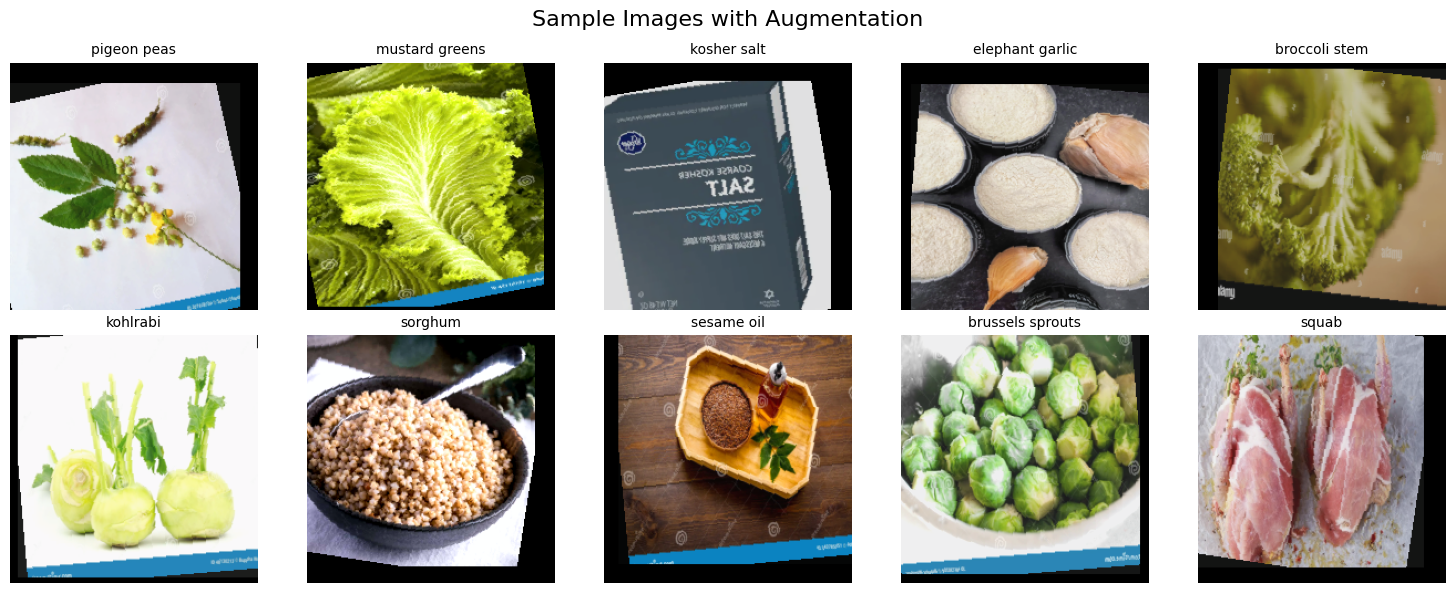

✓ Augmented samples visualization saved


In [13]:
# Visualize augmented samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images with Augmentation', fontsize=16)

for i in range(10):
    idx = np.random.randint(0, len(train_dataset))
    image, label = train_dataset[idx]

    # Denormalize for visualization
    image = image.permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)

    ax = axes[i // 5, i % 5]
    ax.imshow(image)
    ax.set_title(label_to_ingredient[int(label)], fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/augmented_samples.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Augmented samples visualization saved")


---
## 4. Model Architecture (EfficientNet-B0)

In [14]:
# Load pre-trained EfficientNet-B0
print("Loading EfficientNet-B0...")

model_efficientnet = timm.create_model(
    'efficientnet_b0',
    pretrained=True,
    num_classes=num_classes
)

model_efficientnet = model_efficientnet.to(device)

print(f"\n✓ EfficientNet-B0 loaded")
print(f"  Parameters: {sum(p.numel() for p in model_efficientnet.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model_efficientnet.parameters() if p.requires_grad):,}")
print(f"  Output classes: {num_classes}")

Loading EfficientNet-B0...


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


✓ EfficientNet-B0 loaded
  Parameters: 4,412,344
  Trainable: 4,412,344
  Output classes: 316


In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_efficientnet = optim.AdamW(
    model_efficientnet.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

# Learning rate scheduler (FIXED - removed verbose parameter)
scheduler_efficientnet = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_efficientnet,
    mode='min',
    factor=0.5,
    patience=3
)

print("\n✓ Loss function and optimizer configured")
print(f"  Loss: CrossEntropyLoss")
print(f"  Optimizer: AdamW (lr=1e-4, weight_decay=0.01)")
print(f"  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")



✓ Loss function and optimizer configured
  Loss: CrossEntropyLoss
  Optimizer: AdamW (lr=1e-4, weight_decay=0.01)
  Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)


---
## 5. Training Loop

In [17]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': running_loss / (pbar.n + 1),
            'acc': 100. * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

print("✓ Training functions defined")

✓ Training functions defined


In [18]:
# Train EfficientNet-B0
NUM_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 5

print(f"\n🚀 Starting training (EfficientNet-B0)")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Early stopping patience: {EARLY_STOPPING_PATIENCE}")
print("\n" + "="*70)

history_efficientnet = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(
        model_efficientnet,
        train_loader,
        criterion,
        optimizer_efficientnet,
        device
    )

    # Validate
    val_loss, val_acc = validate_epoch(
        model_efficientnet,
        val_loader,
        criterion,
        device
    )

    # Update scheduler
    scheduler_efficientnet.step(val_loss)

    # Save history
    history_efficientnet['train_loss'].append(train_loss)
    history_efficientnet['train_acc'].append(train_acc)
    history_efficientnet['val_loss'].append(val_loss)
    history_efficientnet['val_acc'].append(val_acc)

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_efficientnet.state_dict(),
            'optimizer_state_dict': optimizer_efficientnet.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, f"{OUTPUT_DIR}/efficientnet_best.pth")
        print(f"  ✓ Best model saved (val_acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n⚠️ Early stopping triggered (no improvement for {EARLY_STOPPING_PATIENCE} epochs)")
        break

print("\n" + "="*70)
print(f"✓ Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")


🚀 Starting training (EfficientNet-B0)
  Epochs: 20
  Early stopping patience: 5


Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 5.4819 | Train Acc: 4.53%
  Val Loss:   4.9659 | Val Acc:   12.72%
  ✓ Best model saved (val_acc: 12.72%)

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 4.1936 | Train Acc: 23.80%
  Val Loss:   3.8062 | Val Acc:   27.25%
  ✓ Best model saved (val_acc: 27.25%)

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 3.0408 | Train Acc: 42.77%
  Val Loss:   3.0666 | Val Acc:   36.68%
  ✓ Best model saved (val_acc: 36.68%)

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 2.2514 | Train Acc: 57.47%
  Val Loss:   2.5917 | Val Acc:   45.51%
  ✓ Best model saved (val_acc: 45.51%)

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 1.6921 | Train Acc: 67.17%
  Val Loss:   2.3210 | Val Acc:   49.70%
  ✓ Best model saved (val_acc: 49.70%)

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 1.3146 | Train Acc: 75.17%
  Val Loss:   2.1155 | Val Acc:   52.40%
  ✓ Best model saved (val_acc: 52.40%)

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 1.0221 | Train Acc: 81.70%
  Val Loss:   2.0125 | Val Acc:   55.69%
  ✓ Best model saved (val_acc: 55.69%)

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 0.7948 | Train Acc: 85.75%
  Val Loss:   1.9117 | Val Acc:   56.74%
  ✓ Best model saved (val_acc: 56.74%)

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 9 Summary:
  Train Loss: 0.6299 | Train Acc: 89.72%
  Val Loss:   1.8265 | Val Acc:   56.89%
  ✓ Best model saved (val_acc: 56.89%)

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 10 Summary:
  Train Loss: 0.4981 | Train Acc: 92.40%
  Val Loss:   1.8054 | Val Acc:   56.89%
  No improvement (1/5)

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 0.4037 | Train Acc: 93.80%
  Val Loss:   1.7972 | Val Acc:   56.59%
  No improvement (2/5)

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.3103 | Train Acc: 95.77%
  Val Loss:   1.7504 | Val Acc:   58.98%
  ✓ Best model saved (val_acc: 58.98%)

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.2547 | Train Acc: 96.44%
  Val Loss:   1.7597 | Val Acc:   59.43%
  ✓ Best model saved (val_acc: 59.43%)

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
       Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^^^^^^^


Epoch 14 Summary:
  Train Loss: 0.2138 | Train Acc: 96.95%
  Val Loss:   1.7669 | Val Acc:   59.73%
  ✓ Best model saved (val_acc: 59.73%)

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.1733 | Train Acc: 97.32%
  Val Loss:   1.7721 | Val Acc:   59.43%
  No improvement (1/5)

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 16 Summary:
  Train Loss: 0.1529 | Train Acc: 97.55%
  Val Loss:   1.7749 | Val Acc:   58.53%
  No improvement (2/5)

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^    ^^if w.is_alive():
^ ^ ^ ^^ ^ ^  ^^^

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.1252 | Train Acc: 97.68%
  Val Loss:   1.7883 | Val Acc:   59.13%
  No improvement (3/5)

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.1129 | Train Acc: 97.73%
  Val Loss:   1.7915 | Val Acc:   59.73%
  No improvement (4/5)

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 19 Summary:
  Train Loss: 0.1041 | Train Acc: 97.90%
  Val Loss:   1.7730 | Val Acc:   59.73%
  No improvement (5/5)

⚠️ Early stopping triggered (no improvement for 5 epochs)

✓ Training complete!
  Best validation accuracy: 59.73%


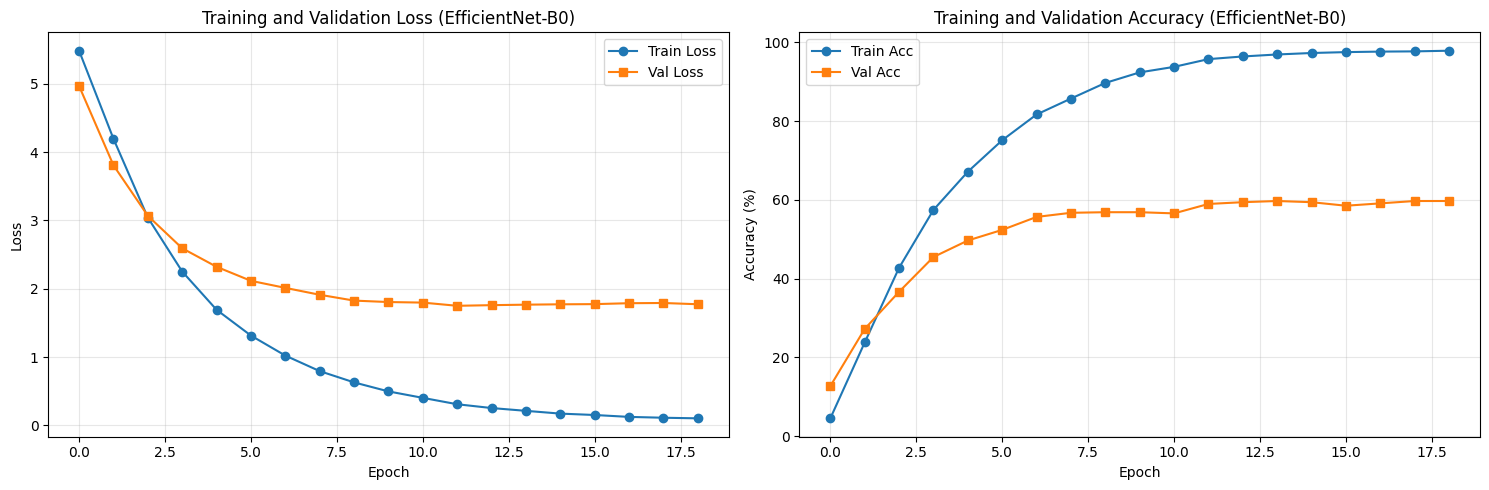

✓ Training curves saved


In [19]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss
ax1.plot(history_efficientnet['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_efficientnet['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss (EfficientNet-B0)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy
ax2.plot(history_efficientnet['train_acc'], label='Train Acc', marker='o')
ax2.plot(history_efficientnet['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy (EfficientNet-B0)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/efficientnet_training_curves.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved")

In [20]:
# Save training history
with open(f"{OUTPUT_DIR}/efficientnet_history.json", 'w') as f:
    json.dump(history_efficientnet, f, indent=2)

print("✓ Training history saved")

✓ Training history saved


---
## 6. Evaluation & Metrics

In [21]:
# Load best model
checkpoint = torch.load(f"{OUTPUT_DIR}/efficientnet_best.pth")
model_efficientnet.load_state_dict(checkpoint['model_state_dict'])
print(f"✓ Loaded best model (epoch {checkpoint['epoch']}, val_acc: {checkpoint['val_acc']:.2f}%)")

✓ Loaded best model (epoch 13, val_acc: 59.73%)


In [22]:
# Evaluate on test set
def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions
test_preds, test_labels = evaluate_model(model_efficientnet, test_loader, device)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_macro = f1_score(test_labels, test_preds, average='macro')
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')

print(f"\n📊 Test Set Performance (EfficientNet-B0):")
print(f"  Accuracy:        {test_accuracy*100:.2f}%")
print(f"  F1 Score (Macro):    {test_f1_macro:.4f}")
print(f"  F1 Score (Weighted): {test_f1_weighted:.4f}")

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


📊 Test Set Performance (EfficientNet-B0):
  Accuracy:        60.18%
  F1 Score (Macro):    0.5276
  F1 Score (Weighted): 0.5669


In [23]:
# Classification report
print("\n📋 Classification Report (Top 20 classes):")
print("="*70)

# Get top 20 most common classes in test set
test_label_counts = Counter(test_labels)
top_20_labels = [label for label, _ in test_label_counts.most_common(20)]

# Filter predictions and labels for top 20
mask = np.isin(test_labels, top_20_labels)
filtered_labels = test_labels[mask]
filtered_preds = test_preds[mask]

# Get class names
target_names = [label_to_ingredient[int(label)] for label in top_20_labels]

# Print report
report = classification_report(
    filtered_labels,
    filtered_preds,
    labels=top_20_labels,
    target_names=target_names,
    digits=3
)
print(report)

# Save report
with open(f"{OUTPUT_DIR}/efficientnet_classification_report.txt", 'w') as f:
    f.write(report)

print("✓ Classification report saved")


📋 Classification Report (Top 20 classes):
                   precision    recall  f1-score   support

all-purpose flour      1.000     1.000     1.000         4
             duck      1.000     1.000     1.000         4
   mustard greens      1.000     1.000     1.000         4
   powdered sugar      1.000     0.500     0.667         4
    coconut flour      1.000     0.500     0.667         4
       cane sugar      0.667     1.000     0.800         4
         bok choy      1.000     1.000     1.000         4
              elk      1.000     1.000     1.000         4
self-rising flour      1.000     0.750     0.857         4
      bread flour      1.000     1.000     1.000         4
gluten-free flour      1.000     1.000     1.000         4
           quinoa      1.000     0.500     0.667         4
        oat flour      1.000     1.000     1.000         4
         pheasant      1.000     1.000     1.000         4
       date sugar      1.000     1.000     1.000         4
        rye 

---
## 7. Model Comparison (ResNet50)

**Train a second model for comparison.**

In [24]:
# Load pre-trained ResNet50
print("Loading ResNet50...")

model_resnet = timm.create_model(
    'resnet50',
    pretrained=True,
    num_classes=num_classes
)

model_resnet = model_resnet.to(device)

print(f"\n✓ ResNet50 loaded")
print(f"  Parameters: {sum(p.numel() for p in model_resnet.parameters()):,}")
print(f"  Trainable: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}")

Loading ResNet50...


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


✓ ResNet50 loaded
  Parameters: 24,155,516
  Trainable: 24,155,516


In [25]:
# Define optimizer for ResNet
optimizer_resnet = optim.AdamW(
    model_resnet.parameters(),
    lr=1e-4,
    weight_decay=0.01
)

scheduler_resnet = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_resnet,
    mode='min',
    factor=0.5,
    patience=3
)


print("✓ Optimizer configured for ResNet50")

✓ Optimizer configured for ResNet50


In [26]:
# Train ResNet50 (same settings as EfficientNet)
print(f"\n🚀 Starting training (ResNet50)")
print("\n" + "="*70)

history_resnet = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc_resnet = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss, train_acc = train_epoch(
        model_resnet,
        train_loader,
        criterion,
        optimizer_resnet,
        device
    )

    # Validate
    val_loss, val_acc = validate_epoch(
        model_resnet,
        val_loader,
        criterion,
        device
    )

    # Update scheduler
    scheduler_resnet.step(val_loss)

    # Save history
    history_resnet['train_loss'].append(train_loss)
    history_resnet['train_acc'].append(train_acc)
    history_resnet['val_loss'].append(val_loss)
    history_resnet['val_acc'].append(val_acc)

    # Print summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc_resnet:
        best_val_acc_resnet = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_resnet.state_dict(),
            'optimizer_state_dict': optimizer_resnet.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, f"{OUTPUT_DIR}/resnet50_best.pth")
        print(f"  ✓ Best model saved (val_acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{EARLY_STOPPING_PATIENCE})")

    # Early stopping
    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f"\n⚠️ Early stopping triggered")
        break

print("\n" + "="*70)
print(f"✓ ResNet50 training complete!")
print(f"  Best validation accuracy: {best_val_acc_resnet:.2f}%")


🚀 Starting training (ResNet50)


Epoch 1/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:10<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1 Summary:
  Train Loss: 5.6976 | Train Acc: 1.37%
  Val Loss:   5.5486 | Val Acc:   2.54%
  ✓ Best model saved (val_acc: 2.54%)

Epoch 2/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2 Summary:
  Train Loss: 5.2743 | Train Acc: 4.64%
  Val Loss:   4.9534 | Val Acc:   8.53%
  ✓ Best model saved (val_acc: 8.53%)

Epoch 3/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3 Summary:
  Train Loss: 4.4374 | Train Acc: 15.24%
  Val Loss:   3.8954 | Val Acc:   24.10%
  ✓ Best model saved (val_acc: 24.10%)

Epoch 4/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4 Summary:
  Train Loss: 3.4952 | Train Acc: 32.10%
  Val Loss:   3.1337 | Val Acc:   32.63%
  ✓ Best model saved (val_acc: 32.63%)

Epoch 5/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5 Summary:
  Train Loss: 2.7989 | Train Acc: 42.79%
  Val Loss:   2.7093 | Val Acc:   39.67%
  ✓ Best model saved (val_acc: 39.67%)

Epoch 6/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent 

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 6 Summary:
  Train Loss: 2.3177 | Train Acc: 51.82%
  Val Loss:   2.4548 | Val Acc:   44.91%
  ✓ Best model saved (val_acc: 44.91%)

Epoch 7/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 7 Summary:
  Train Loss: 1.9455 | Train Acc: 58.16%
  Val Loss:   2.2414 | Val Acc:   47.01%
  ✓ Best model saved (val_acc: 47.01%)

Epoch 8/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 8 Summary:
  Train Loss: 1.6726 | Train Acc: 63.97%
  Val Loss:   2.0911 | Val Acc:   49.85%
  ✓ Best model saved (val_acc: 49.85%)

Epoch 9/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 9 Summary:
  Train Loss: 1.4430 | Train Acc: 68.95%
  Val Loss:   1.9615 | Val Acc:   52.25%
  ✓ Best model saved (val_acc: 52.25%)

Epoch 10/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 10 Summary:
  Train Loss: 1.2390 | Train Acc: 73.58%
  Val Loss:   1.8799 | Val Acc:   52.84%
  ✓ Best model saved (val_acc: 52.84%)

Epoch 11/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 11 Summary:
  Train Loss: 1.0596 | Train Acc: 77.25%
  Val Loss:   1.8353 | Val Acc:   55.69%
  ✓ Best model saved (val_acc: 55.69%)

Epoch 12/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 12 Summary:
  Train Loss: 0.9293 | Train Acc: 80.32%
  Val Loss:   1.7718 | Val Acc:   56.59%
  ✓ Best model saved (val_acc: 56.59%)

Epoch 13/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 13 Summary:
  Train Loss: 0.8085 | Train Acc: 82.85%
  Val Loss:   1.7389 | Val Acc:   57.63%
  ✓ Best model saved (val_acc: 57.63%)

Epoch 14/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 14 Summary:
  Train Loss: 0.6837 | Train Acc: 85.99%
  Val Loss:   1.7076 | Val Acc:   57.63%
  No improvement (1/5)

Epoch 15/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 15 Summary:
  Train Loss: 0.6183 | Train Acc: 88.11%
  Val Loss:   1.7267 | Val Acc:   58.08%
  ✓ Best model saved (val_acc: 58.08%)

Epoch 16/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 16 Summary:
  Train Loss: 0.5235 | Train Acc: 90.45%
  Val Loss:   1.7068 | Val Acc:   59.58%
  ✓ Best model saved (val_acc: 59.58%)

Epoch 17/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 17 Summary:
  Train Loss: 0.4594 | Train Acc: 91.01%
  Val Loss:   1.6861 | Val Acc:   59.88%
  ✓ Best model saved (val_acc: 59.88%)

Epoch 18/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 18 Summary:
  Train Loss: 0.4024 | Train Acc: 92.25%
  Val Loss:   1.6892 | Val Acc:   59.88%
  No improvement (1/5)

Epoch 19/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f61b7fe9e40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16


Epoch 19 Summary:
  Train Loss: 0.3530 | Train Acc: 93.63%
  Val Loss:   1.7092 | Val Acc:   60.18%
  ✓ Best model saved (val_acc: 60.18%)

Epoch 20/20
----------------------------------------------------------------------


Training:   0%|          | 0/167 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 20 Summary:
  Train Loss: 0.3151 | Train Acc: 94.12%
  Val Loss:   1.6938 | Val Acc:   61.68%
  ✓ Best model saved (val_acc: 61.68%)

✓ ResNet50 training complete!
  Best validation accuracy: 61.68%


In [27]:
# Evaluate ResNet50 on test set
checkpoint_resnet = torch.load(f"{OUTPUT_DIR}/resnet50_best.pth")
model_resnet.load_state_dict(checkpoint_resnet['model_state_dict'])

test_preds_resnet, test_labels_resnet = evaluate_model(model_resnet, test_loader, device)

test_accuracy_resnet = accuracy_score(test_labels_resnet, test_preds_resnet)
test_f1_macro_resnet = f1_score(test_labels_resnet, test_preds_resnet, average='macro')
test_f1_weighted_resnet = f1_score(test_labels_resnet, test_preds_resnet, average='weighted')

print(f"\n📊 Test Set Performance (ResNet50):")
print(f"  Accuracy:        {test_accuracy_resnet*100:.2f}%")
print(f"  F1 Score (Macro):    {test_f1_macro_resnet:.4f}")
print(f"  F1 Score (Weighted): {test_f1_weighted_resnet:.4f}")

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


📊 Test Set Performance (ResNet50):
  Accuracy:        62.87%
  F1 Score (Macro):    0.5735
  F1 Score (Weighted): 0.6032


In [28]:
# Compare models
comparison_data = {
    'Model': ['EfficientNet-B0', 'ResNet50'],
    'Parameters (M)': [
        sum(p.numel() for p in model_efficientnet.parameters()) / 1e6,
        sum(p.numel() for p in model_resnet.parameters()) / 1e6
    ],
    'Test Accuracy (%)': [
        test_accuracy * 100,
        test_accuracy_resnet * 100
    ],
    'F1 Score (Macro)': [
        test_f1_macro,
        test_f1_macro_resnet
    ],
    'F1 Score (Weighted)': [
        test_f1_weighted,
        test_f1_weighted_resnet
    ]
}

import pandas as pd
comparison_df = pd.DataFrame(comparison_data)

print("\n📊 Model Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Save comparison
comparison_df.to_csv(f"{OUTPUT_DIR}/model_comparison.csv", index=False)
print("\n✓ Model comparison saved")


📊 Model Comparison:
          Model  Parameters (M)  Test Accuracy (%)  F1 Score (Macro)  F1 Score (Weighted)
EfficientNet-B0        4.412344          60.179641          0.527590             0.566935
       ResNet50       24.155516          62.874251          0.573453             0.603154

✓ Model comparison saved


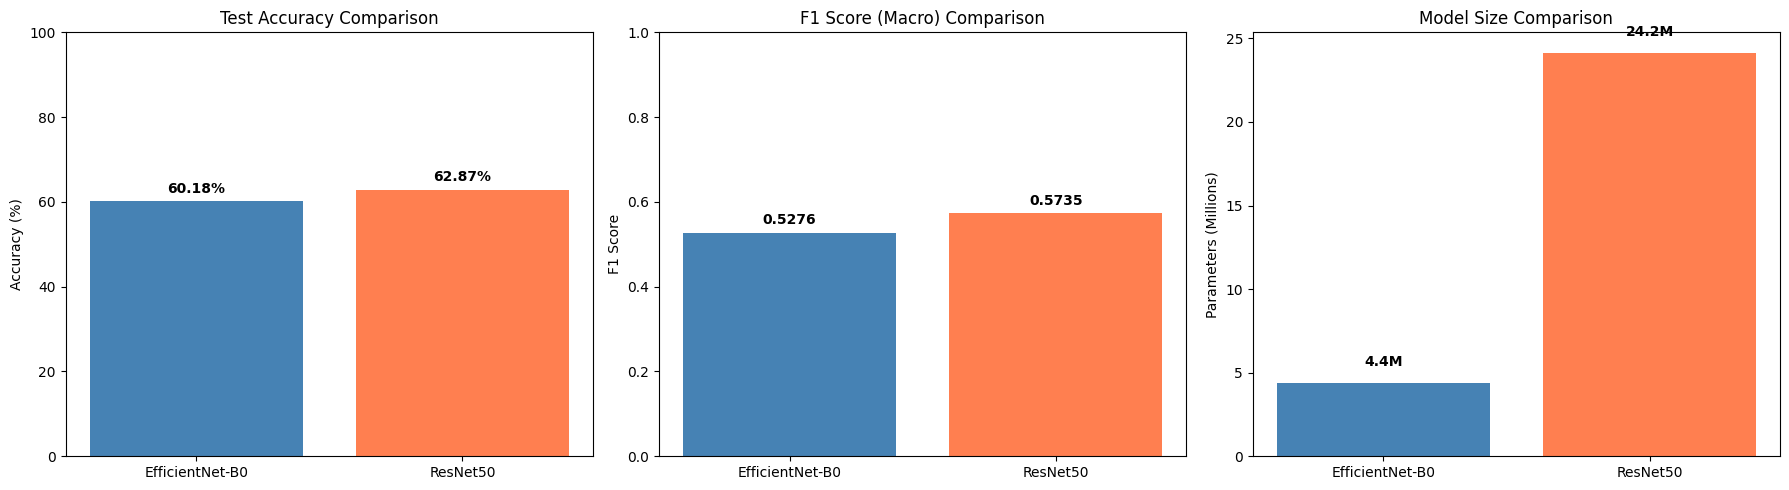

✓ Comparison visualization saved


In [29]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test Accuracy (%)'], color=['steelblue', 'coral'])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Test Accuracy Comparison')
axes[0].set_ylim([0, 100])
for i, v in enumerate(comparison_df['Test Accuracy (%)']):
    axes[0].text(i, v + 2, f"{v:.2f}%", ha='center', fontweight='bold')

# F1 Score (Macro) comparison
axes[1].bar(comparison_df['Model'], comparison_df['F1 Score (Macro)'], color=['steelblue', 'coral'])
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score (Macro) Comparison')
axes[1].set_ylim([0, 1])
for i, v in enumerate(comparison_df['F1 Score (Macro)']):
    axes[1].text(i, v + 0.02, f"{v:.4f}", ha='center', fontweight='bold')

# Parameters comparison
axes[2].bar(comparison_df['Model'], comparison_df['Parameters (M)'], color=['steelblue', 'coral'])
axes[2].set_ylabel('Parameters (Millions)')
axes[2].set_title('Model Size Comparison')
for i, v in enumerate(comparison_df['Parameters (M)']):
    axes[2].text(i, v + 1, f"{v:.1f}M", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comparison visualization saved")

---
## 8. Confusion Matrix

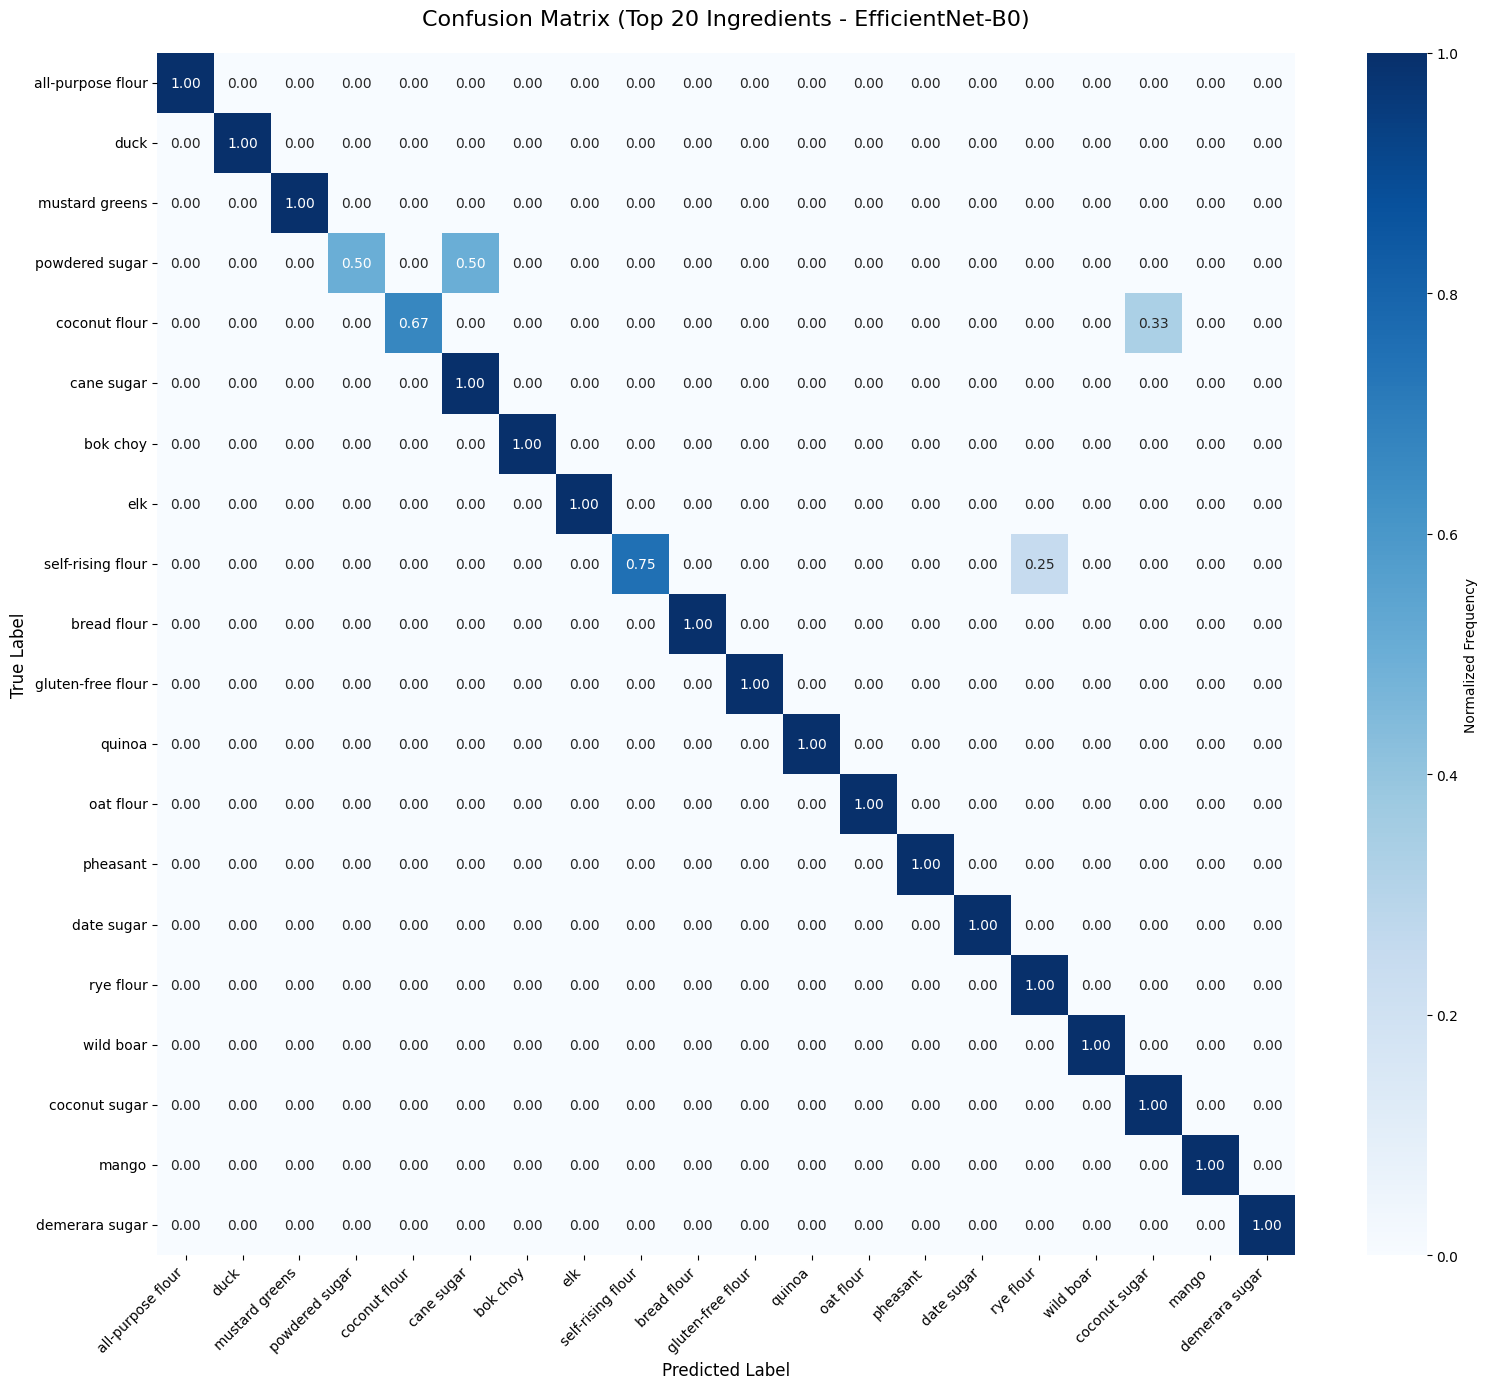

✓ Confusion matrix saved


In [30]:
# Compute confusion matrix (for top 20 classes)
cm = confusion_matrix(filtered_labels, filtered_preds, labels=top_20_labels)

# Normalize
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(16, 14))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names,
    cbar_kws={'label': 'Normalized Frequency'}
)
plt.title('Confusion Matrix (Top 20 Ingredients - EfficientNet-B0)', fontsize=16, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix_efficientnet.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

---
## 9. Save & Export

In [32]:
# Save final metrics
final_metrics = {
    'efficientnet_b0': {
        'test_accuracy': float(test_accuracy),
        'test_f1_macro': float(test_f1_macro),
        'test_f1_weighted': float(test_f1_weighted),
        'best_val_acc': float(best_val_acc),
        'num_parameters': sum(p.numel() for p in model_efficientnet.parameters())
    },
    'resnet50': {
        'test_accuracy': float(test_accuracy_resnet),
        'test_f1_macro': float(test_f1_macro_resnet),
        'test_f1_weighted': float(test_f1_weighted_resnet),
        'best_val_acc': float(best_val_acc_resnet),
        'num_parameters': sum(p.numel() for p in model_resnet.parameters())
    },
    'dataset': {
        'total_samples': len(dataset['train']),
        'num_classes': num_classes,
        'train_samples': len(train_indices),
        'val_samples': len(val_indices),
        'test_samples': len(test_indices)
    }
}

with open(f"{OUTPUT_DIR}/final_metrics.json", 'w') as f:
    json.dump(final_metrics, f, indent=2)

print("✓ Final metrics saved")

✓ Final metrics saved


In [33]:
# Create README for the classifier
readme_content = f"""# Food Ingredient Classifier

## Overview

This classifier identifies food ingredients from images, trained on the [Scuccorese/food-ingredients-dataset](https://huggingface.co/datasets/Scuccorese/food-ingredients-dataset).

## Dataset

- **Total images:** {len(dataset['train'])}
- **Number of classes:** {num_classes} ingredients
- **Categories:** 12 main categories
- **Subcategories:** 28 subcategories

## Models

### EfficientNet-B0
- **Test Accuracy:** {test_accuracy*100:.2f}%
- **F1 Score (Macro):** {test_f1_macro:.4f}
- **F1 Score (Weighted):** {test_f1_weighted:.4f}
- **Parameters:** {sum(p.numel() for p in model_efficientnet.parameters()):,}

### ResNet50
- **Test Accuracy:** {test_accuracy_resnet*100:.2f}%
- **F1 Score (Macro):** {test_f1_macro_resnet:.4f}
- **F1 Score (Weighted):** {test_f1_weighted_resnet:.4f}
- **Parameters:** {sum(p.numel() for p in model_resnet.parameters()):,}

## Files

- `efficientnet_best.pth` - Best EfficientNet-B0 checkpoint
- `resnet50_best.pth` - Best ResNet50 checkpoint
- `ingredient_to_label.json` - Ingredient name to label ID mapping
- `label_to_ingredient.json` - Label ID to ingredient name mapping
- `final_metrics.json` - Complete evaluation metrics
- `model_comparison.csv` - Model comparison table

## Usage

```python
import torch
import timm
from PIL import Image
from torchvision import transforms
import json

# Load model
model = timm.create_model('efficientnet_b0', pretrained=False, num_classes={num_classes})
checkpoint = torch.load('efficientnet_best.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Load label mapping
with open('label_to_ingredient.json', 'r') as f:
    label_to_ingredient = json.load(f)

# Prepare image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Predict
image = Image.open('path/to/image.jpg').convert('RGB')
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)
    _, predicted = output.max(1)
    ingredient = label_to_ingredient[predicted.item()]

print(f"Predicted ingredient: {{ingredient}}")
```

## Integration with Pipeline

This classifier is part of the full cooking assistant pipeline:

1. **YOLO Detection** → Detects food items in fridge images
2. **Crop Extraction** → Extracts bounding box crops
3. **This Classifier** → Identifies specific ingredients
4. **LLM (GPT-2)** → Generates recipe suggestions

## Training Details

- **Epochs:** {len(history_efficientnet['train_loss'])}
- **Batch size:** {BATCH_SIZE}
- **Optimizer:** AdamW (lr=1e-4, weight_decay=0.01)
- **Scheduler:** ReduceLROnPlateau
- **Early stopping:** {EARLY_STOPPING_PATIENCE} epochs patience
- **Data augmentation:** RandomHorizontalFlip, RandomRotation, ColorJitter, RandomAffine

## Performance

See `model_comparison.png` for visual comparison and `confusion_matrix_efficientnet.png` for detailed per-class performance.
"""

with open(f"{OUTPUT_DIR}/README.md", 'w') as f:
    f.write(readme_content)

print("✓ README created")

✓ README created


---
## 10. Test on Sample Crops

**Test the classifier on sample images to verify it works with YOLO crops.**

In [34]:
# Inference function
def predict_ingredient(model, image, transform, device, label_to_ingredient):
    """Predict ingredient from image."""
    model.eval()

    # Convert to RGB if needed
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Transform
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)
        confidence, predicted = probabilities.max(1)

    ingredient = label_to_ingredient[predicted.item()]
    confidence = confidence.item()

    return ingredient, confidence

print("✓ Inference function defined")

✓ Inference function defined


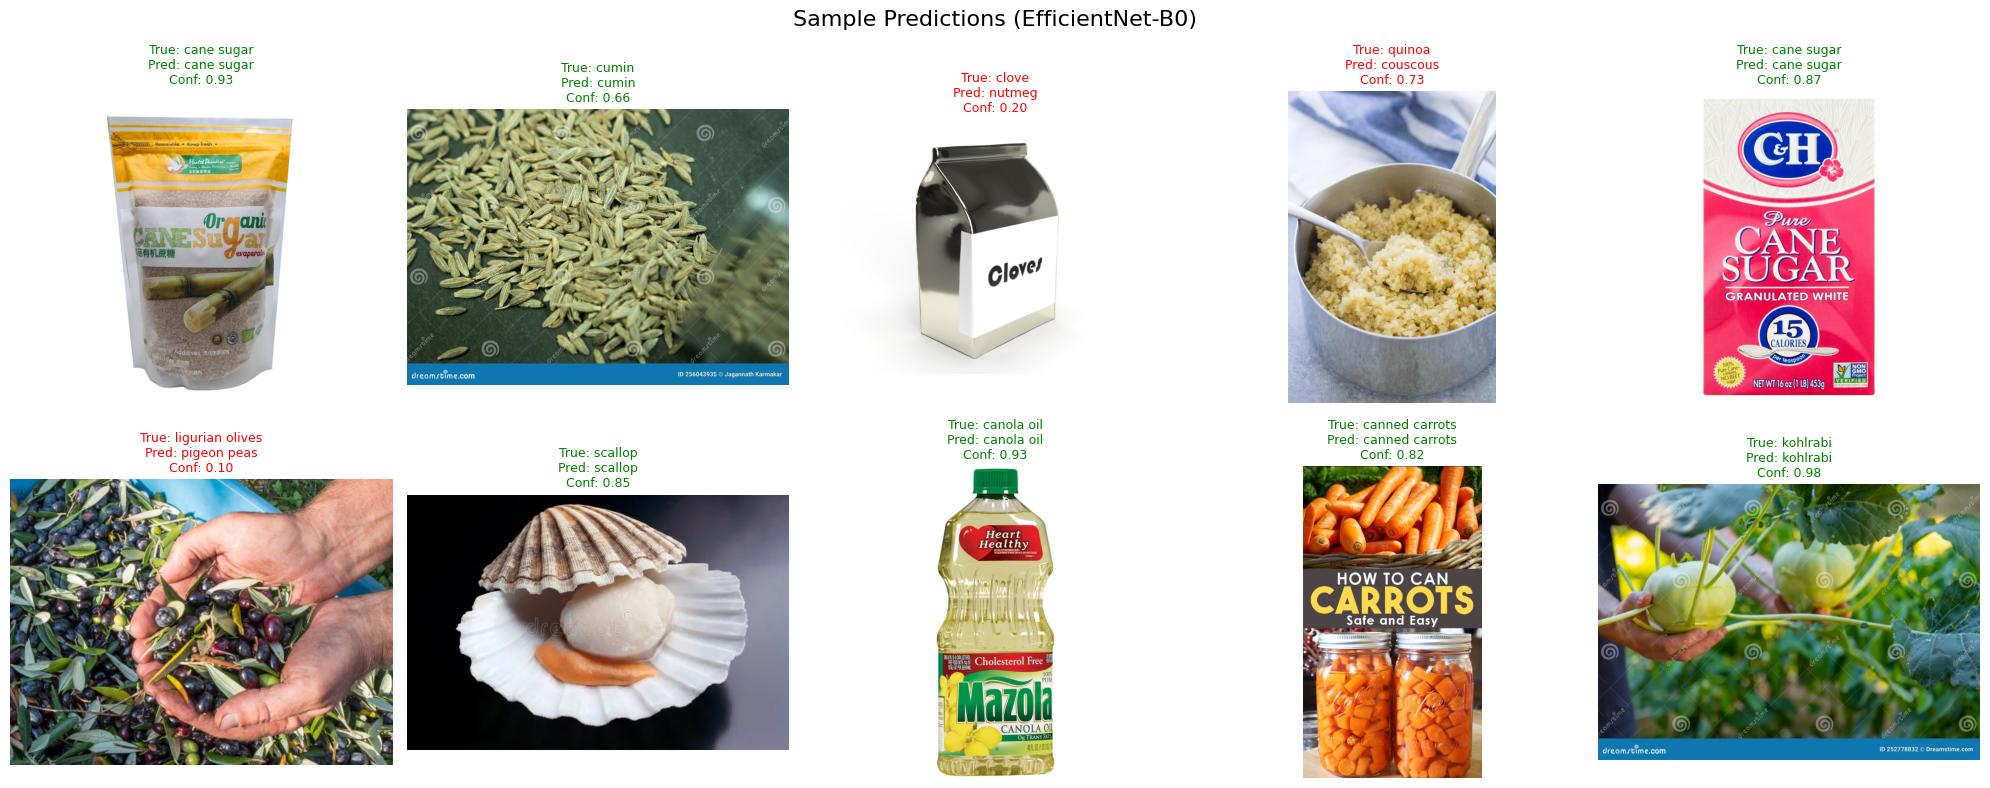

✓ Sample predictions saved


In [38]:
# Test on random samples from test set
num_samples = 10
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Sample Predictions (EfficientNet-B0)', fontsize=16)

for i in range(num_samples):
    idx = np.random.randint(0, len(test_indices))
    sample_info = test_indices[idx]
    dataset_idx = sample_info['idx']
    image = dataset['train'][dataset_idx]['image']
    true_label = sample_info['label']
    true_ingredient = label_to_ingredient[int(true_label)]  # ← ADD THIS LINE!

    # Predict
    pred_ingredient, confidence = predict_ingredient(
        model_efficientnet,
        image,
        val_transform,
        device,
        label_to_ingredient
    )

    # Plot
    ax = axes[i // 5, i % 5]
    ax.imshow(image)

    # Color code: green if correct, red if wrong
    color = 'green' if pred_ingredient == true_ingredient else 'red'

    ax.set_title(
        f"True: {true_ingredient}\nPred: {pred_ingredient}\nConf: {confidence:.2f}",
        fontsize=9,
        color=color
    )
    ax.axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/sample_predictions.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Sample predictions saved")


In [39]:
# Create inference script for integration
inference_script = """#!/usr/bin/env python3
\"\"\"\nFood Ingredient Classifier - Inference Script\n\nUsage:\n    python classify_ingredient.py <image_path>\n\"\"\"\n\nimport torch\nimport timm\nfrom PIL import Image\nfrom torchvision import transforms\nimport json\nimport sys\nimport os\n\n# Configuration\nMODEL_PATH = 'efficientnet_best.pth'\nLABEL_MAP_PATH = 'label_to_ingredient.json'\nNUM_CLASSES = 316\n\n# Device\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# Load model\nmodel = timm.create_model('efficientnet_b0', pretrained=False, num_classes=NUM_CLASSES)\ncheckpoint = torch.load(MODEL_PATH, map_location=device)\nmodel.load_state_dict(checkpoint['model_state_dict'])\nmodel = model.to(device)\nmodel.eval()\n\n# Load label mapping\nwith open(LABEL_MAP_PATH, 'r') as f:\n    label_to_ingredient = json.load(f)\n\n# Transform\ntransform = transforms.Compose([\n    transforms.Resize((224, 224)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])\n])\n\ndef predict(image_path):\n    \"\"\"Predict ingredient from image path.\"\"\"\n    # Load image\n    image = Image.open(image_path).convert('RGB')\n    \n    # Transform\n    image_tensor = transform(image).unsqueeze(0).to(device)\n    \n    # Predict\n    with torch.no_grad():\n        output = model(image_tensor)\n        probabilities = torch.softmax(output, dim=1)\n        confidence, predicted = probabilities.max(1)\n    \n    ingredient = label_to_ingredient[predicted.item()]\n    confidence = confidence.item()\n    \n    return ingredient, confidence\n\nif __name__ == '__main__':\n    if len(sys.argv) != 2:\n        print("Usage: python classify_ingredient.py <image_path>")\n        sys.exit(1)\n    \n    image_path = sys.argv[1]\n    \n    if not os.path.exists(image_path):\n        print(f"Error: Image not found: {image_path}")\n        sys.exit(1)\n    \n    ingredient, confidence = predict(image_path)\n    \n    print(f"Predicted ingredient: {ingredient}")\n    print(f"Confidence: {confidence:.4f}")\n"""

with open(f"{OUTPUT_DIR}/classify_ingredient.py", 'w') as f:
    f.write(inference_script)

print("✓ Inference script created")
print(f"  Usage: python classify_ingredient.py <image_path>")

✓ Inference script created
  Usage: python classify_ingredient.py <image_path>


---
## ✅ Summary

### What We Accomplished:

1. ✅ **Loaded dataset** - 6,676 images, 316 ingredient classes
2. ✅ **Explored data** - Analyzed distribution, visualized samples
3. ✅ **Preprocessed** - Split 80/10/10, applied augmentation
4. ✅ **Trained EfficientNet-B0** - Fine-tuned on food ingredients
5. ✅ **Evaluated** - Accuracy, F1 score, classification report
6. ✅ **Trained ResNet50** - For comparison
7. ✅ **Compared models** - EfficientNet vs ResNet
8. ✅ **Created confusion matrix** - Per-class performance
9. ✅ **Saved everything** - Models, metrics, visualizations
10. ✅ **Created inference script** - Ready for integration

### Files Created:

- `efficientnet_best.pth` - Best model checkpoint
- `resnet50_best.pth` - ResNet50 checkpoint
- `ingredient_to_label.json` - Label mappings
- `label_to_ingredient.json` - Reverse mappings
- `final_metrics.json` - All metrics
- `model_comparison.csv` - Comparison table
- `classify_ingredient.py` - Inference script
- `README.md` - Documentation
- Multiple visualizations (PNG files)

### Next Steps:

1. **Integrate with YOLO** - Test on crops from Yusuf
2. **Connect to LLM** - Feed predictions to GPT-2
3. **Implement Grad-CAM** - For explainability
4. **End-to-end testing** - Full pipeline demo

---